In [1]:
import pandas as pd
import numpy as np
import random
import itertools as it

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.features import build_features
from src.tournaments import utilities
from src.visualization import visualize

from trueskill import Rating

In [2]:
data = pd.read_excel('../data/raw/data_pato_tournaments.xlsx', header=None,
                     names=['playerA1', 'playerA2', 'scoreA', 'vs', 'playerB1', 'playerB2', 'scoreB'])

data.head()

def get_result(row):
  if(row['scoreA'] > row['scoreB']):
    result = 1
  else:
    result = 0
  return result

data['result'] = data.apply (lambda row: get_result(row), axis=1)

In [3]:
players_names = set(list(data['playerA1'])+list(data['playerA2'])+list(data['playerB1'])+list(data['playerB2']))
players = { i : [Rating()] for i in players_names }
players

{'Rodrigo Z': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Daniel': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Agustin': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Patricio': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Rodrigo H': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Alonso': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Alfonso': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Sergio': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Andres': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Jose': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Fernando': [trueskill.Rating(mu=25.000, sigma=8.333)],
 'Alejandro': [trueskill.Rating(mu=25.000, sigma=8.333)]}

In [4]:
[build_features.update_TrueSkill(players, row[0], row[1], row[2], row[3], row[4]) for row in zip(data['playerA1'], data['playerA2'], data['playerB1'], data['playerB2'], data['result'])]

['Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado']

In [5]:
sorted([[name, skills[-1]] for name, skills in players.items()], key=lambda item: item[1], reverse=True)

[['Alejandro', trueskill.Rating(mu=35.365, sigma=5.485)],
 ['Patricio', trueskill.Rating(mu=33.035, sigma=5.003)],
 ['Sergio', trueskill.Rating(mu=29.151, sigma=5.241)],
 ['Rodrigo H', trueskill.Rating(mu=28.588, sigma=6.028)],
 ['Alfonso', trueskill.Rating(mu=28.072, sigma=5.254)],
 ['Andres', trueskill.Rating(mu=27.513, sigma=6.205)],
 ['Daniel', trueskill.Rating(mu=25.577, sigma=4.948)],
 ['Jose', trueskill.Rating(mu=20.850, sigma=6.317)],
 ['Fernando', trueskill.Rating(mu=20.850, sigma=6.317)],
 ['Alonso', trueskill.Rating(mu=18.103, sigma=5.177)],
 ['Agustin', trueskill.Rating(mu=17.074, sigma=5.514)],
 ['Rodrigo Z', trueskill.Rating(mu=14.177, sigma=5.393)]]

In [6]:
sorted([[name, build_features.calculate_score_TrueSkill(skills[-1])] for name, skills in players.items()], key=lambda item: item[1], reverse=True)

[['Alejandro', 18.909165187324128],
 ['Patricio', 18.025931866698087],
 ['Sergio', 13.428509235058101],
 ['Alfonso', 12.308629067390033],
 ['Daniel', 10.731547975509084],
 ['Rodrigo H', 10.504805680249376],
 ['Andres', 8.898980785603225],
 ['Alonso', 2.5723458033294406],
 ['Jose', 1.8981697178198829],
 ['Fernando', 1.8981697178198829],
 ['Agustin', 0.531739966837101],
 ['Rodrigo Z', -2.000898286969502]]

In [7]:
ranking = sorted([[name, build_features.calculate_score_TrueSkill(skills[-1])] for name, skills in players.items()], key=lambda item: item[1], reverse=True)

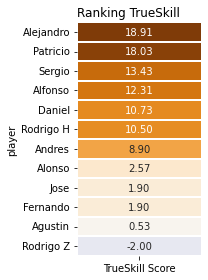

In [8]:
df_ranking = pd.DataFrame(ranking, columns=['player', 'TrueSkill Score']).set_index('player')

visualize.plot_players_metric_pivoted(df_ranking, 'ranking', 'Ranking TrueSkill')

In [9]:
utilities.predict_match_result(players, ['Alejandro', 'Daniel'], ['Sergio', 'Alonso'])


[1, 0.8473377000833527]

In [10]:
utilities.print_result(players, ['Alejandro', 'Daniel'], ['Alonso', 'Patricio'])

Gana ['Alejandro', 'Daniel'] a ['Alonso', 'Patricio'] con probabilidad 0.7701367599519653


# Matchup Matrix Prediction

In [11]:
matchups = []
players_list = list(players_names)

for p1_name in players_list:
    players_list_tmp = players_list.copy()
    players_list_tmp.remove(p1_name)
    mu_rows = list(zip([p1_name]*len(players_list_tmp), players_list_tmp))

    for r in mu_rows:
        p2_name = r[1]
        players_list_tmp2 = players_list_tmp.copy()
        players_list_tmp2.remove(p2_name)
        for op1_name, op2_name in it.combinations(sorted(players_list_tmp2), 2):

            score = utilities.predict_match_result(players, [p1_name, p2_name], [op1_name, op2_name])[1]
            matchups.append([f'{p1_name}, {p2_name}', f'{op1_name}, {op2_name}', 100*score])

df_mu = pd.DataFrame(matchups, columns=['teamA', 'teamB', 'score'])

In [12]:
df_mu_pivot = df_mu.pivot_table(index='teamA',columns='teamB', values='score', aggfunc='mean')

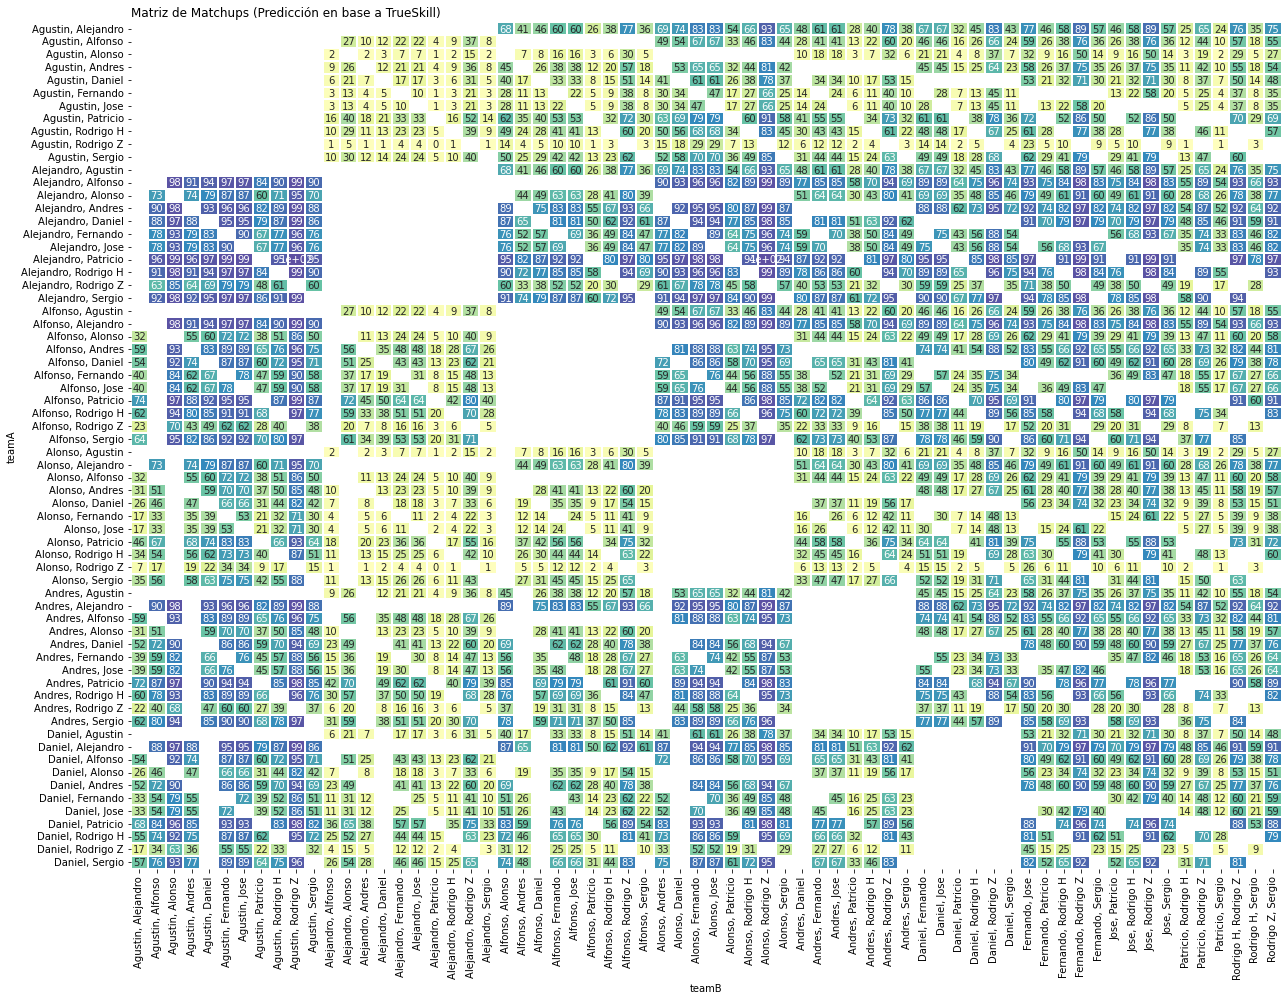

In [13]:
visualize.plot_mu_matrix(df_mu_pivot.iloc[0:int(len(df_mu_pivot)/2)].round(0), 'mu_matrix_1')

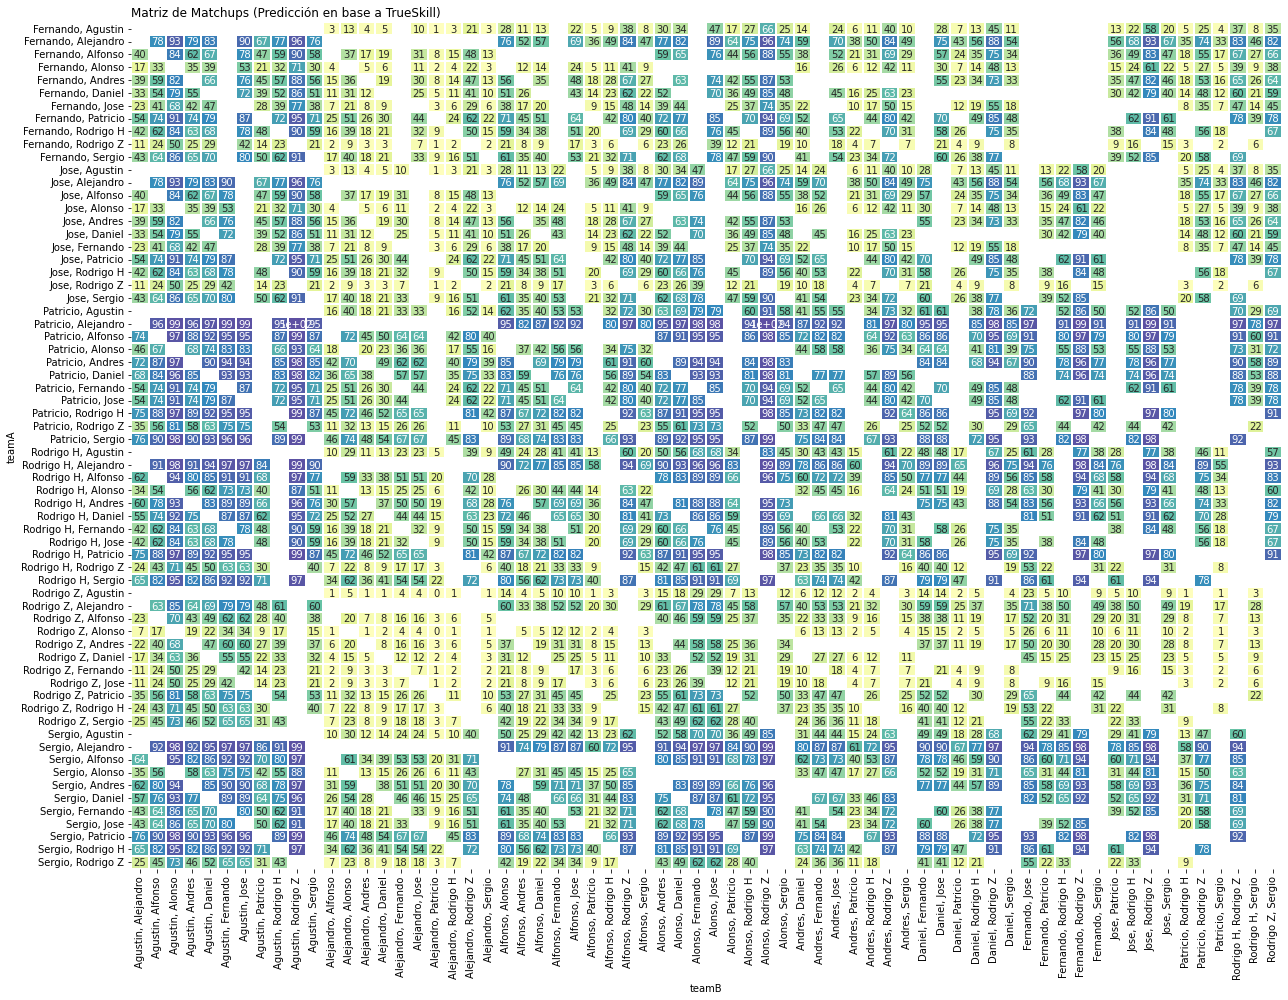

In [14]:
visualize.plot_mu_matrix(df_mu_pivot.iloc[int(len(df_mu_pivot)/2):].round(0), 'mu_matrix_2')

# Escenario 1: Pareja Fija

## Escenario 1A: Parejas al Azar

In [214]:
players = build_features.init_players(data)
champs = []
points_total = dict.fromkeys(players, 0)
for k in range(10000):
  players_escenario = build_features.init_players(data)
  players_names_sorted = sorted(players_escenario.items(), key=lambda item: item[1], reverse=True)
  random.shuffle(players_names_sorted)
  teams = []
  nplayers = len(players_names_sorted)
  for i in range(6):
    teams.append([players_names_sorted[i][0], players_names_sorted[nplayers-i-1][0]])
  fixture = utilities.simulate_draw(teams)
  points_escenario = dict.fromkeys(players_escenario, 0)
  for m in fixture:
    r = utilities.get_winner_team_ts(players_escenario, [m[0][0], m[0][1]], [m[1][0], m[1][1]])
    build_features.update_TrueSkill(players_escenario, m[0][0], m[0][1], m[1][0], m[1][1], r)

    if r == 1:
      points_escenario[m[0][0]] += 1
      points_escenario[m[0][1]] += 1
      points_total[m[0][0]] += 1
      points_total[m[0][1]] += 1
    else:
      points_escenario[m[1][0]] += 1
      points_escenario[m[1][1]] += 1
      points_total[m[1][0]] += 1
      points_total[m[1][1]] += 1
  
  max_points = sorted(points_escenario.items(), key=lambda item: item[1], reverse=True)[0][1]
  champions = [name for name, points in points_escenario.items() if points == max_points]

  champs.append(champions)

In [215]:
df = utilities.get_metrics_from_system(champs, points_total)
df.to_csv('../data/processed/system_metrics_1A.csv', index=False)

## Escenario 1B: Parejas segun TrueSkill (1-12, 2-11, 3-10, ..., 6-7)

In [216]:
players = build_features.init_players(data)
champs = []
points_total = dict.fromkeys(players, 0)
for k in range(10000):
  players_escenario = build_features.init_players(data)
  players_sorted = sorted([[name, build_features.calculate_score_TrueSkill(skills[-1])] for name, skills in players_escenario.items()],
                                                                              key=lambda item: item[1], reverse=True)
  players_names_sorted = [name for name, score in players_sorted]
  
  teams = []
  nplayers = len(players_names_sorted)
  for i in range(6):
    teams.append([players_names_sorted[i], players_names_sorted[nplayers-i-1]])
  
  fixture = utilities.simulate_draw(teams)
  points_escenario = dict.fromkeys(players_escenario, 0)
  for m in fixture:
    r = utilities.get_winner_team_ts(players_escenario, [m[0][0], m[0][1]], [m[1][0], m[1][1]])
    build_features.update_TrueSkill(players_escenario, m[0][0], m[0][1], m[1][0], m[1][1], r)

    if r == 1:
      points_escenario[m[0][0]] += 1
      points_escenario[m[0][1]] += 1
      points_total[m[0][0]] += 1
      points_total[m[0][1]] += 1
    else:
      points_escenario[m[1][0]] += 1
      points_escenario[m[1][1]] += 1
      points_total[m[1][0]] += 1
      points_total[m[1][1]] += 1
  
  
  max_points = sorted(points_escenario.items(), key=lambda item: item[1], reverse=True)[0][1]
  
  champions = [name for name, points in points_escenario.items() if points == max_points]
  
  champs.append(champions)

In [217]:
df = utilities.get_metrics_from_system(champs, points_total)
df.to_csv('../data/processed/system_metrics_1B.csv', index=False)

# Escenario 2: Parejas Dinámicas

## Escenario 2B: Parejas Dinámicas en Base a TrueSkill

In [218]:
players = build_features.init_players(data)
champs = []
points_total = dict.fromkeys(players, 0)
for k in range(10000):
  players_escenario = build_features.init_players(data)
  for j in range(5):
    players_sorted = sorted([[name, build_features.calculate_score_TrueSkill(skills[-1])] for name, skills in players_escenario.items()],
                                                                                key=lambda item: item[1], reverse=True)
    players_names_sorted = [name for name, score in players_sorted]
    
    teams = []
    nplayers = len(players_names_sorted)
    for i in range(6):
        teams.append([players_names_sorted[i], players_names_sorted[nplayers-i-1]])
    
    fixture = utilities.simulate_draw(teams)
    points_escenario = dict.fromkeys(players_escenario, 0)
    for m in fixture[0:3]:
        r = utilities.get_winner_team_ts(players_escenario, [m[0][0], m[0][1]], [m[1][0], m[1][1]])
        build_features.update_TrueSkill(players_escenario, m[0][0], m[0][1], m[1][0], m[1][1], r)

        if r == 1:
            points_escenario[m[0][0]] += 1
            points_escenario[m[0][1]] += 1
            points_total[m[0][0]] += 1
            points_total[m[0][1]] += 1
        else:
            points_escenario[m[1][0]] += 1
            points_escenario[m[1][1]] += 1
            points_total[m[1][0]] += 1
            points_total[m[1][1]] += 1
    
    
  max_points = sorted(points_escenario.items(), key=lambda item: item[1], reverse=True)[0][1]
    
  champions = [name for name, points in points_escenario.items() if points == max_points]
  
  champs.append(champions)

In [219]:
df = utilities.get_metrics_from_system(champs, points_total)
df.to_csv('../data/processed/system_metrics_2B.csv', index=False)

# Visualizaciones

In [15]:
df1 = pd.read_csv('../data/processed/system_metrics_1A.csv')
df1['system'] = '1A_random_fixed_pair'

df2 = pd.read_csv('../data/processed/system_metrics_1B.csv')
df2['system'] = '1B_ts_fixed_pair'

df3 = pd.read_csv('../data/processed/system_metrics_2B.csv')
df3['system'] = '2B_ts_dynamic_pair'

df = pd.concat([df1, df2, df3])
df.head()


,player,champ_wr,match_wr,system
0,Alejandro,0.4644,0.74062,1A_random_fixed_pair
1,Patricio,0.3763,0.69244,1A_random_fixed_pair
2,Sergio,0.2681,0.60014,1A_random_fixed_pair
3,Rodrigo H,0.2675,0.59028,1A_random_fixed_pair
4,Andres,0.2398,0.55944,1A_random_fixed_pair


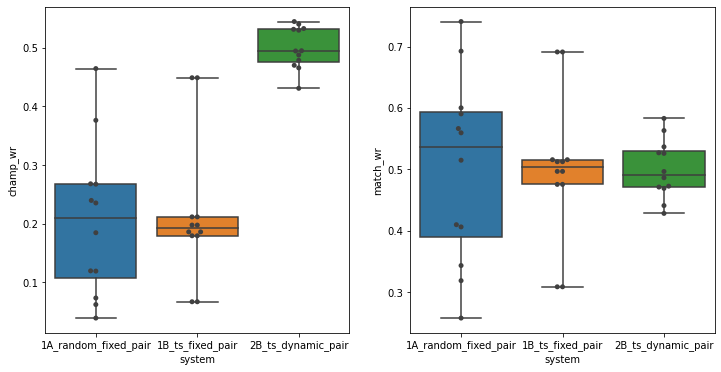

In [16]:
visualize.plot_box_plot(df, 'tournament_system_metrics')

In [17]:
df.groupby('system').std().round(2)

,champ_wr,match_wr
system,,
1A_random_fixed_pair,0.13,0.15
1B_ts_fixed_pair,0.12,0.12
2B_ts_dynamic_pair,0.04,0.05


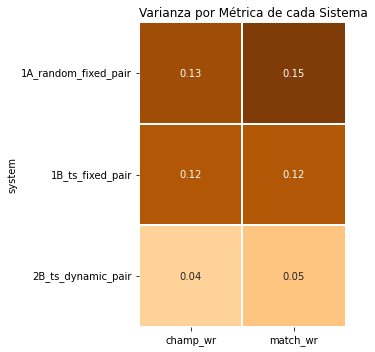

In [18]:
visualize.plot_tournament_metric_pivoted(df.groupby('system').std().round(2), 'std_system', 'Varianza por Métrica de cada Sistema')

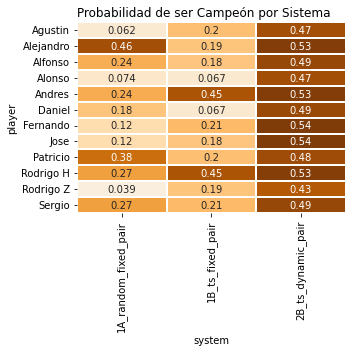

In [19]:
visualize.plot_tournament_metric(df, 'champ_wr', 'Probabilidad de ser Campeón por Sistema')

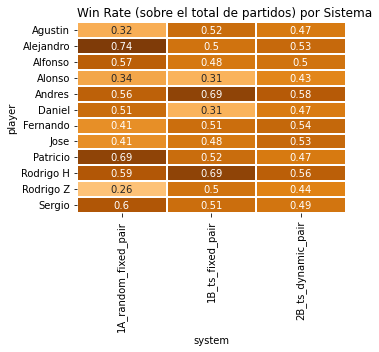

In [20]:
visualize.plot_tournament_metric(df, 'match_wr', 'Win Rate (sobre el total de partidos) por Sistema')